# Notebook to check parent/child grids are aligned based on the bondaries 

In [1]:
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from xhistogram.xarray import histogram
from datetime import datetime

import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

#Cartopy stuff - put this here so it's not buried somewhere in the notebook
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

from dask.distributed import Client

client = Client()
client

2023-01-20 11:18:27,201 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-rfj4hdcj', purging
2023-01-20 11:18:27,202 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5gudctkt', purging
2023-01-20 11:18:27,202 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-m_17k7yf', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43767,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.65 GiB
Comm: tcp://127.0.0.1:36655,Total threads: 4
Dashboard: http://127.0.0.1:36519/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:42041,


## Open the model output

In [2]:
#Parent grid - not associated with the child grid. 
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
# path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/10min/ocean_avg_0000*.nc')

ds_parent = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds_parent, grid_parent = xroms.roms_dataset(ds_parent)

#Child grid - hourly output
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')

ds_child = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds_child, grid_child = xroms.roms_dataset(ds_child)

In [3]:
xisliceparent = slice(271,404)
etasliceparent = slice(31,149)

xislicechild = slice(8, 677-8)
etaslicechild = slice(8, 602-8)

### Plot the parent and child grid. The parent grid should just barely be outside of the child domain because of the interpolation from nesting. If any of the parent boundaries are 'inside' of the child grid, we've gone too far. Then zoom in to get a closer look

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/d2/home/dylan/.conda/envs/copano/lib/py

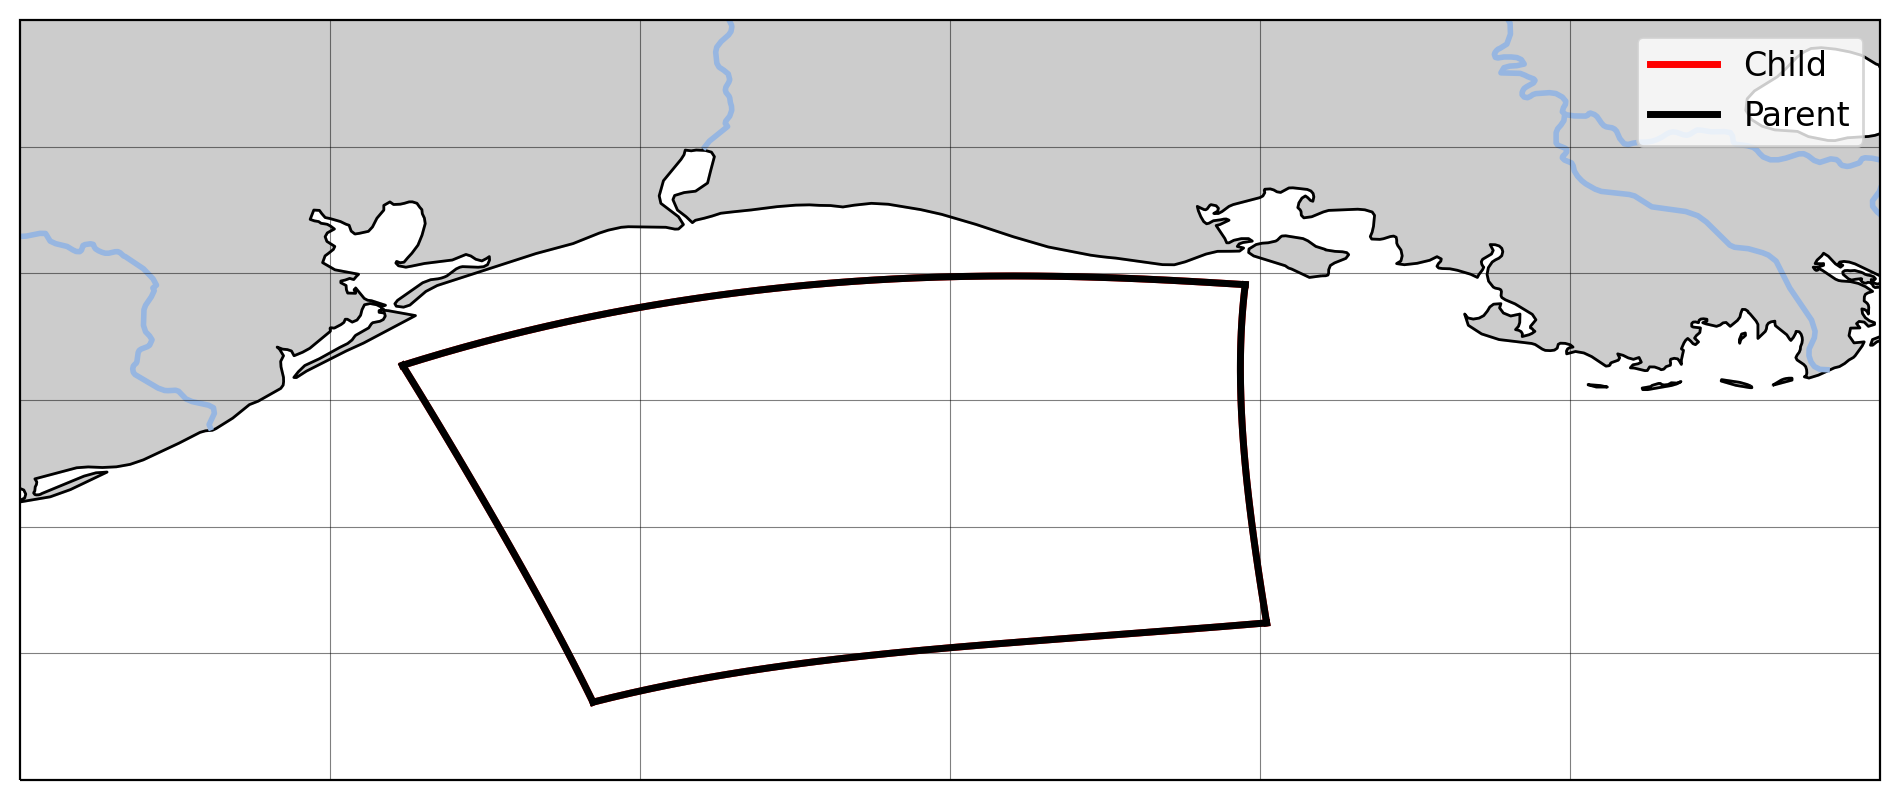

In [4]:
fig = plt.figure(figsize=(10,4), dpi = 200)

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-92.0))

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -90, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = False

ax.plot(ds_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).lon_rho[0,:], ds_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).lat_rho[0,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),label = 'Child')
ax.plot(ds_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).lon_rho[:,0], ds_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).lat_rho[:,0], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).lon_rho[:,-1], ds_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).lat_rho[:,-1], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).lon_rho[-1,:], ds_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).lat_rho[-1,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)

ax.plot(ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[0,:], ds_parent.lat_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[0,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(), label = 'Parent')
ax.plot(ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,0], ds_parent.lat_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,0], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,-1], ds_parent.lat_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,-1], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[-1,:], ds_parent.lat_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[-1,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)

ax.legend()

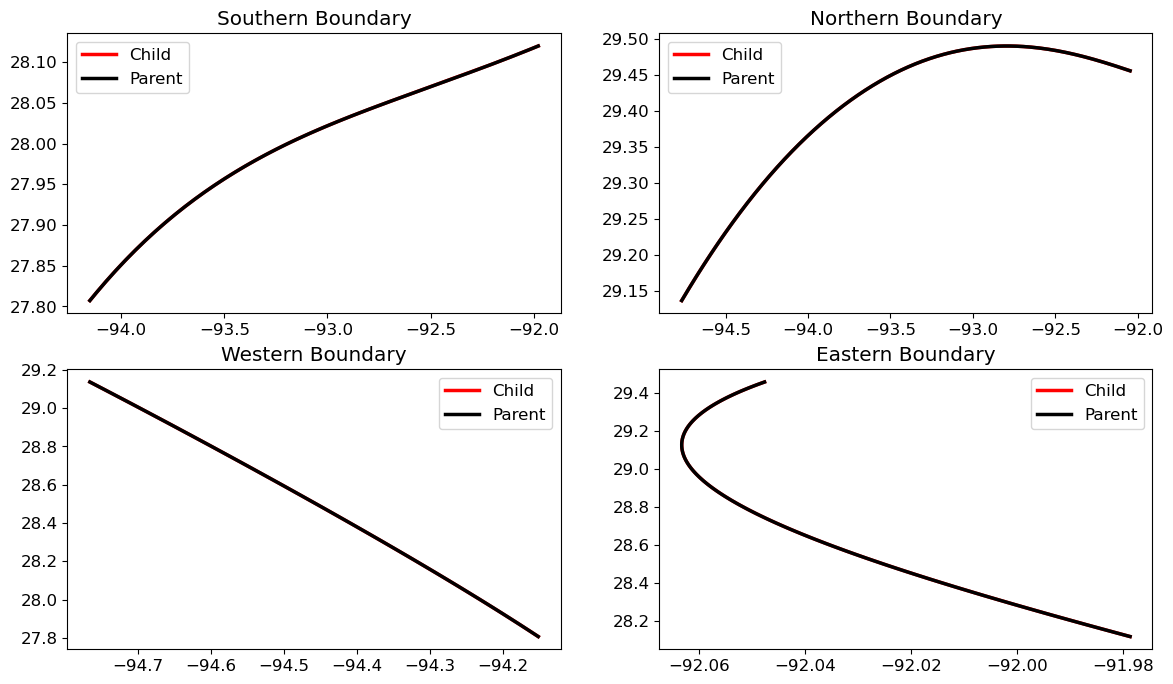

In [5]:
fig, ax = plt.subplots(2,2, figsize = (14,8))
ax[0,0].plot(ds_child.lon_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[0,:], 
             ds_child.lat_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[0,:], 'r', lw=2.5, label = 'Child')
ax[0,0].plot(ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[0,:], 
             ds_parent.lat_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[0,:], 
             'k', lw=2.5, label = 'Parent')
ax[0,0].set_title('Southern Boundary')
ax[0,0].legend()

ax[1,0].plot(ds_child.lon_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[:,0], 
             ds_child.lat_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[:,0], 'r', lw=2.5, label = 'Child')
ax[1,0].plot(ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,0], 
             ds_parent.lat_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,0], 
             'k', lw=2.5, label = 'Parent')
ax[1,0].set_title('Western Boundary')
ax[1,0].legend()

ax[1,1].plot(ds_child.lon_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[:,-1], 
             ds_child.lat_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[:,-1], 'r', lw=2.5, label = 'Child')
ax[1,1].plot(ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,-1], 
             ds_parent.lat_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,-1], 
             'k', lw=2.5, label = 'Parent')
ax[1,1].set_title('Eastern Boundary')
ax[1,1].legend()

ax[0,1].plot(ds_child.lon_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[-1,:], 
             ds_child.lat_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[-1,:], 'r', lw=2.5, label = 'Child')
ax[0,1].plot(ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[-1,:], 
             ds_parent.lat_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[-1,:], 
             'k', lw=2.5, label = 'Parent')
ax[0,1].set_title('Northern Boundary')
ax[0,1].legend()

In [6]:
print(ds_child.lon_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[0,::5].values-ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[0,:].values)
print(ds_child.lon_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[-1,::5].values-ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[-1,:].values)
print(ds_child.lon_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[::5,0].values-ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,0].values)
print(ds_child.lon_rho.isel(eta_rho = etaslicechild, xi_rho = xislicechild)[::5,-1].values-ds_parent.lon_rho.isel(eta_rho = etasliceparent, xi_rho = xisliceparent)[:,-1].values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.